# ARIMA Model

First, we'll take a look at the ARIMA model. The ARIMA model is from the same family of models as the VAR model which we have discussed previously, they're from the Autoregression modelling family. ARIMA stands for:\
i) AR - AutoRegressive - uses the relationship between a feature and its path to make predictions of the future,\
ii) I - Integrated -Involves differencing the time series to make it stationary,\
iii) MA - Moving Average - Models the relationship between an observation and a residual error from a moving average model applied to lagged observations.

It's similar to the VAR model, however it used for a single time series where we have one observed variable. In our case, this will be the value of the pollution.

## Importing required libraries

In [87]:
#For data wrangling
import numpy as np
import pandas as pd
#To load the data
import pickle 
#Importing our model
from statsmodels.tsa.arima.model import ARIMA
#For visualisation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Assessing performance of the model
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
#To time how long it takes to run
import time
#To see if data is stationary
from statsmodels.tsa.stattools import adfuller

## Load the data

In [88]:
#Training data
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

We'll start by taking a look at our training data

In [89]:
train_data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.000000
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.000000
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.000000
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.000000
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.000000
...,...,...,...,...,...,...,...,...
2014-07-02 07:00:00,0.058350,0.882353,0.655738,0.236364,0.333333,0.003811,0.000000,0.000000
2014-07-02 08:00:00,0.057344,0.882353,0.672131,0.236364,1.000000,0.000752,0.000000,0.027778
2014-07-02 09:00:00,0.052314,0.897059,0.672131,0.236364,0.333333,0.000752,0.000000,0.055556


## Visualising the data

Only interested in the pollution as the ARIMA model only takes one variable and this is the one we're interested in. We want to visualise how pollution changes over time and see what the data looks like.

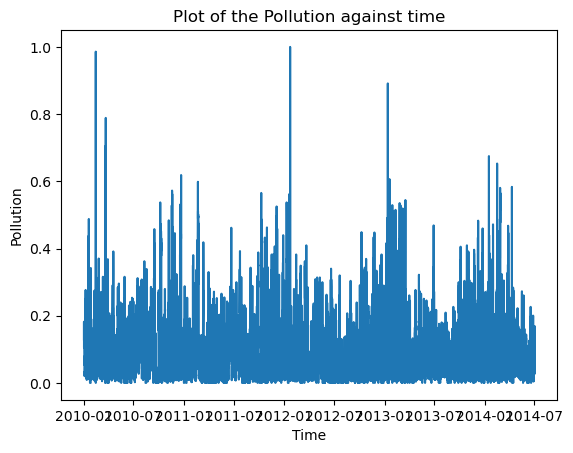

In [90]:
#Isolating pollution variable
variable_of_interest = train_data['pollution']

#Plotting pollution against time
plt.plot(variable_of_interest)
plt.title('Plot of the Pollution against time')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.show()

We can see a trend of the pollution being pretty cyclical, it's at its peak during the winter months and at its lowest during the summer months, producing a sinusodial looking graph. The reason for this is because cold air in denser than warm air and therefore traps more pollution.

We'll now take a look at the correlation graphs for the pollution variable so we can decide how many lags we need to include in our model

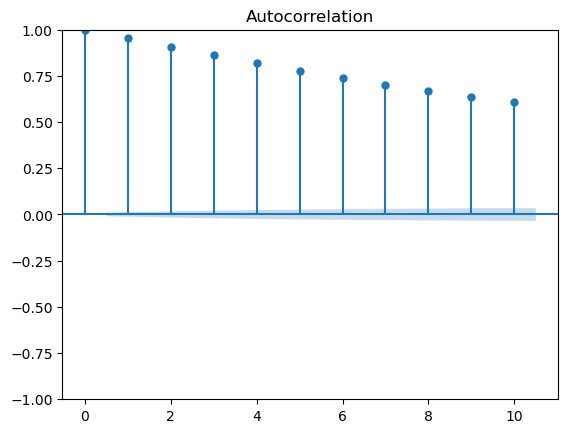

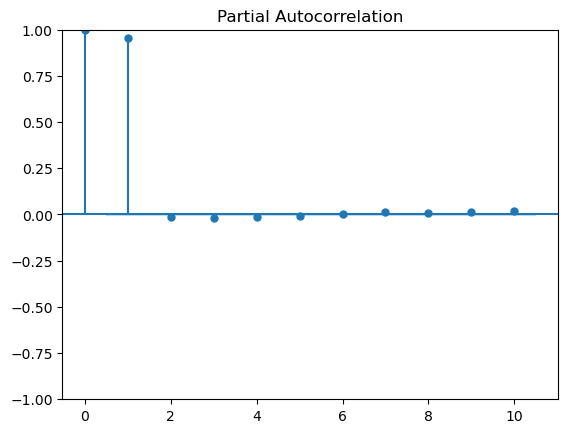

In [91]:
plot_acf(train_data['pollution'].dropna(), lags=10)
plt.show()

plot_pacf(train_data['pollution'].dropna(), lags=10)
plt.show()

The first graph measures how much the time series is correlated to itself at different lags, as we can see it gradually decreases as the amount of lags increases.

The second graph measures how much the time series is correlated to itself at different lags whilst removing the intermediate lag values. As we can see it's highly correlated to the previous lag, but beyond that there's basically 0 correlation.

We'll now check that the data is stationary using the Augmented Dickey-Fuller test if our p-value is less than a significance level, say 0.05, then are data is stationary.

In [92]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data['pollution'])

adf_statistic = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")

ADF Statistic: -19.566524660105763
P-Value: 0.0


Hence, our data is stationary and we can proceed with our diferencing in the ARIMA model equal to 0.

## Creating the validation split

In [93]:
train_size = int(len(train_data) * 0.999)
train_df1 = train_data[:train_size]
val_df = train_data[train_size:]
train_df2 = train_df1[['pollution']]


In [94]:
#Looking at our data
train_df2

,pollution
date,
2010-01-02 00:00:00,0.129779
2010-01-02 01:00:00,0.148893
2010-01-02 02:00:00,0.159960
2010-01-02 03:00:00,0.182093
2010-01-02 04:00:00,0.138833
...,...
2014-06-30 15:00:00,0.074447
2014-06-30 16:00:00,0.072435
2014-06-30 17:00:00,0.051308


## Fitting our initial model

In [95]:
train_df2.index.freq = 'h'
model = ARIMA(train_df2, order=(1, 0, 1))
arima_model = model.fit()

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                39380
Model:                 ARIMA(1, 0, 1)   Log Likelihood               84994.839
Date:                Thu, 21 Nov 2024   AIC                        -169981.678
Time:                        15:50:31   BIC                        -169947.354
Sample:                    01-02-2010   HQIC                       -169970.805
                         - 06-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0951      0.004     23.930      0.000       0.087       0.103
ar.L1          0.9529      0.001    972.417      0.000       0.951       0.955
ma.L1          0.0120      0.001     12.328      0.0

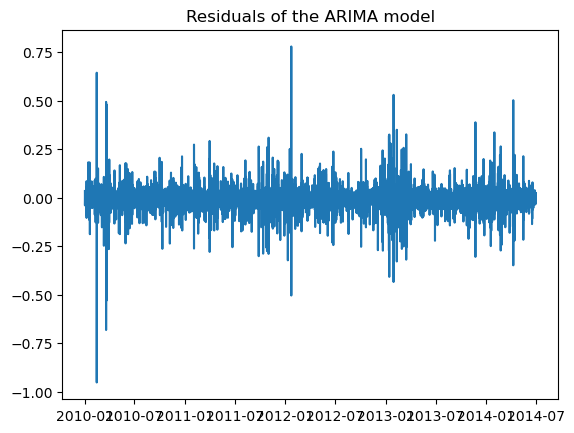

In [96]:
print(arima_model.summary())
residuals = arima_model.resid
plt.plot(residuals)
plt.title("Residuals of the ARIMA model")
plt.show()

In [97]:
forecast = arima_model.forecast(steps=len(val_df))
forecast

2014-06-30 20:00:00    0.042633
2014-06-30 21:00:00    0.045104
2014-06-30 22:00:00    0.047459
2014-06-30 23:00:00    0.049702
2014-07-01 00:00:00    0.051840
2014-07-01 01:00:00    0.053877
2014-07-01 02:00:00    0.055818
2014-07-01 03:00:00    0.057668
2014-07-01 04:00:00    0.059430
2014-07-01 05:00:00    0.061110
2014-07-01 06:00:00    0.062710
2014-07-01 07:00:00    0.064235
2014-07-01 08:00:00    0.065687
2014-07-01 09:00:00    0.067072
2014-07-01 10:00:00    0.068391
2014-07-01 11:00:00    0.069648
2014-07-01 12:00:00    0.070846
2014-07-01 13:00:00    0.071987
2014-07-01 14:00:00    0.073074
2014-07-01 15:00:00    0.074110
2014-07-01 16:00:00    0.075098
2014-07-01 17:00:00    0.076039
2014-07-01 18:00:00    0.076935
2014-07-01 19:00:00    0.077789
2014-07-01 20:00:00    0.078603
2014-07-01 21:00:00    0.079379
2014-07-01 22:00:00    0.080118
2014-07-01 23:00:00    0.080822
2014-07-02 00:00:00    0.081493
2014-07-02 01:00:00    0.082132
2014-07-02 02:00:00    0.082741
2014-07-

In [98]:
mse = mean_squared_error(val_df["pollution"], forecast)
rmse = np.sqrt(mse)
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 0.041199377609662406


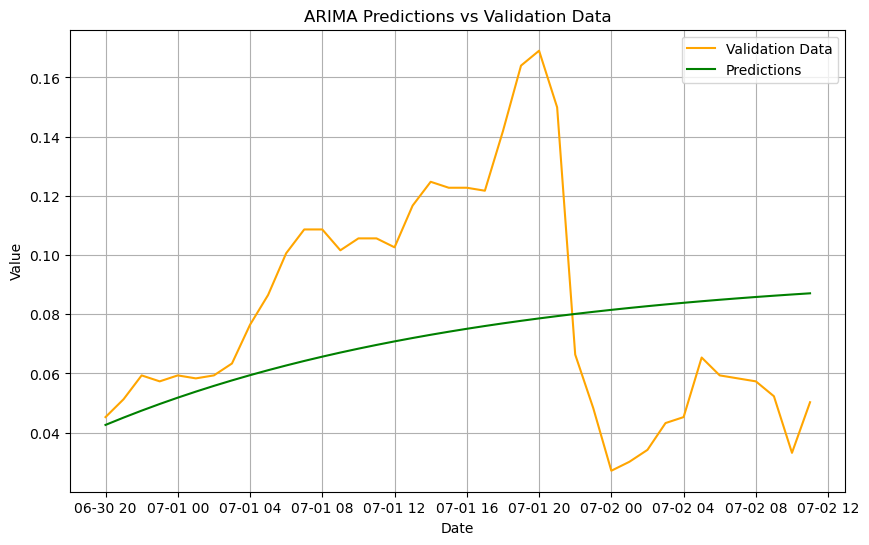

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(val_df["pollution"], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Here, it's obvious that are predictions are tending to a constant value. This is not what we want as it captures none of the variation in the data. We'll next attempt to remedy this with a change in paramters.

## Finding better parameters

We'll run auto_arima which uses corss-validation to find the best parameters for our model.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-169506.387, Time=4.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-47067.814, Time=2.63 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-169508.988, Time=3.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-90386.404, Time=5.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-169506.991, Time=3.55 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-169506.990, Time=2.68 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-169505.334, Time=18.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-169978.479, Time=4.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-75153.464, Time=5.88 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-169981.913, Time=7.66 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-169998.101, Time=6.27 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-170002.751, Time=5.74 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-170002.352, Time=11.79 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-169982.974, Time=9

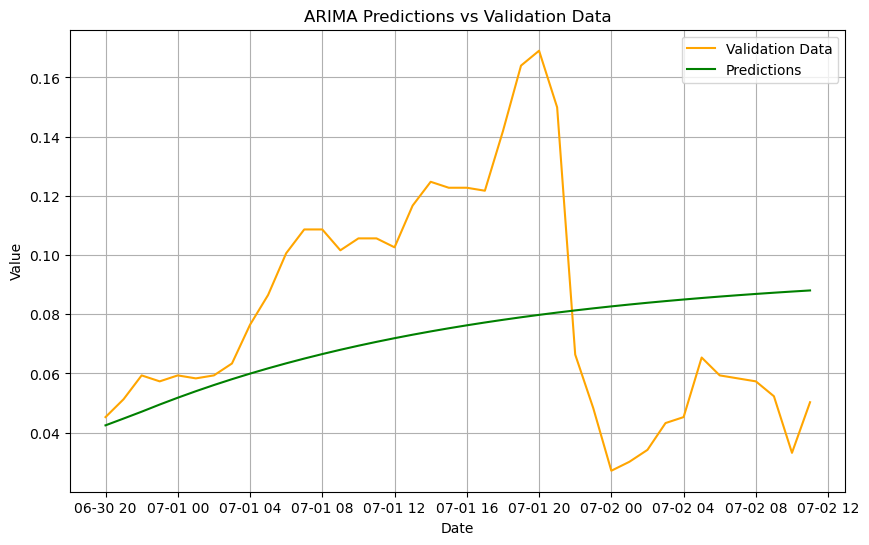

In [100]:
from pmdarima import auto_arima

#Fit the best ARIMA model
auto_model = auto_arima(train_df2, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

#Forecast for the next len(val_df) steps
forecast_auto = auto_model.predict(n_periods=len(val_df))

#Plot our predictions and validation set
print(forecast_auto)

plt.figure(figsize=(10, 6))
plt.plot(val_df["pollution"], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast_auto, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

This looks exactly like what we had previously with our predictions tending to a constant value, we can see below that with a larger validation set this is what happens.

In [101]:
#Creating a training and validation set with a 90/10 split
train_size1 = int(len(train_data) * 0.9)
train_df3 = train_data[:train_size1]
val_df1 = train_data[train_size1:]
train_df4 = train_df3[['pollution']]

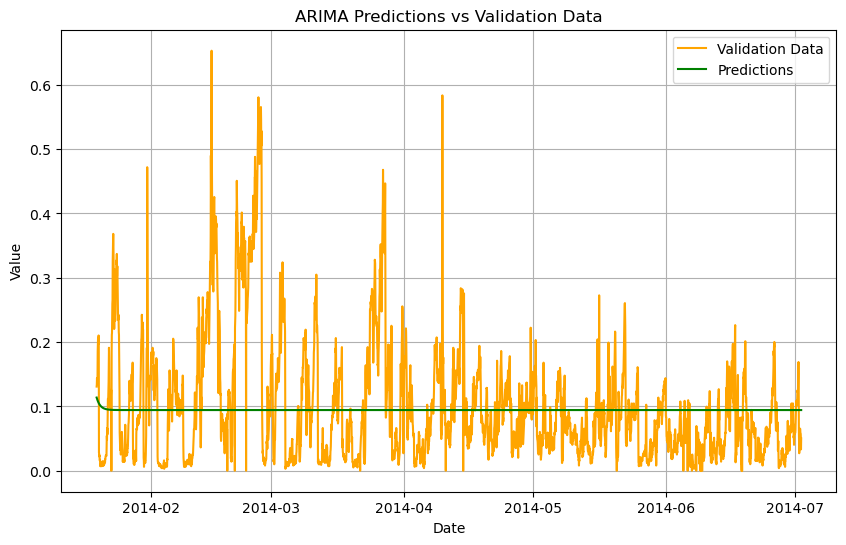

In [102]:
train_df4.index.freq = 'h'
model = ARIMA(train_df4, order=(1, 0, 1))
arima_model = model.fit()

forecast1 = arima_model.forecast(steps=len(val_df1))

plt.figure(figsize=(10, 6))
plt.plot(val_df1["pollution"], label='Validation Data', color='orange')
plt.plot(val_df1.index, forecast1, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

As we can see, our predictions tend to a constant value. This suggests that for our data that the ARIMA model simply isn't appropriate. There's too much data and as there's no discernible pattern on small scales the ARIMA model just predicts a constant value for the whole thing in order to minimise the error.

This makes it a highly inappropraite model for the task at hand. Even on a relatively small amount of data it gives us nothing in the way of predicting pollution levels and this issue would only continue as the amount of data is scaled up. It's not a complex enough model to capture the variation of the pollution over time.